In [1]:
import networkx as nx
#print(nx.__version__)
import csv
import community
import pandas as pd
from itertools import combinations
import itertools
from matplotlib import pyplot as plt
#create an empty graph
G = nx.Graph()

In [2]:
# Open the CSV file and read the data for languages
with open('dataset/languages.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # Add the language node to graph with green color
        G.add_node(row[0], language=row[1], color='#30FBD0')

In [3]:
#create nodes and edges bewtween repositories and languages
with open('dataset/repos.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of languages into an array of strings
        row[2], row[5], row[6] = tuple(x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in (row[2], row[5], row [6]))
        G.add_node(row[0], name=row[1], topics=row[2], n_star=row[3], n_fork=row[4], languages=row[5], p_lang=row[6], color='#5D7EF5')
        # Add the edges between the repository and the languages
        #for lang in row[5]:
         #   G.add_edge(row[0], lang)

In [4]:
# create nodes and edges between users and repositories
with open('dataset/users.csv', 'r') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 0: # Skip the header columns
            continue
        # transform the string of repositories into an array of strings
        row[2:4] = [x.replace(' ', '').replace('[', '').replace(']', '').replace('\'', '').replace('"', '').split(',') for x in row[2:4]]
        # Add the user node to graph with blue color
        G.add_node(row[0], name=row[1], repos=row[2], commits= row[3], color='#F8A643')
        # Add edges between the user and their repositories
        #for repo in row[2]:
         #   G.add_edge(row[0], repo)

In [5]:
# Add edges between users and repositories based on the users' list of repositories
for node in list(G.nodes):
    # if it's a user node
    if len(node) >= 1:
        if node[0] == "u":
            # for each repository in the user's list of repositories
            for repo in G.nodes[node]['repos']:
                # add an edge between the user and the repository
                G.add_edge(node, repo)
        if node[0] == "r":
            # for each language in the repository's list of languages
            for lang in G.nodes[node]['languages']:
                # add an edge between the repository and the language
                G.add_edge(node, lang)     

#nx.info(G)

In [6]:

# Creazione del sottografo contenente solo utenti che hanno contribuito alla stessa repository
users_subgraph = nx.Graph()
for repo_node in G.nodes():
    if repo_node.startswith('r'):
        # Trova la lista degli utenti che hanno contribuito a questo repository
        repo_users = [node for node in G.neighbors(repo_node) if node.startswith('u')]
        # Aggiunge gli utenti e gli archi al sottografo
        for u, v in itertools.combinations(repo_users, 2):
            users_subgraph.add_edge(u, v)

#nx.info(users_subgraph)
#nx.edges(users_subgraph)

In [7]:
#calculate clustering coefficient of users subgraph
clustering_coefficient = nx.average_clustering(users_subgraph)
print("Clustering coefficient: ", clustering_coefficient)

Clustering coefficient:  0.6263838145981003


In [8]:
# view if the subgraph is connected
conn = nx.is_connected(users_subgraph)
print("Connected: ", conn)


Connected:  False


In [9]:
#convert the graph to a directed graph
users_subgraph_d = users_subgraph.to_directed()
def average_shortest_path_length(users_subgraph_d):
    # compute the strongly connected components of the graph
    components = nx.strongly_connected_components(users_subgraph_d)

    # compute the average shortest path length for each component
    avg_shortest_path_lengths = []
    for component in components:
        subgraph = users_subgraph_d.subgraph(component)
        avg_shortest_path_length = nx.average_shortest_path_length(subgraph)
        avg_shortest_path_lengths.append(avg_shortest_path_length)

    # compute the overall average shortest path length
    overall_avg_shortest_path_length = sum(avg_shortest_path_lengths) / len(avg_shortest_path_lengths)

    # print the results
    return overall_avg_shortest_path_length, avg_shortest_path_lengths

def average_degree(users_subgraph_d):
    degree_sequence = sorted([d for n, d in users_subgraph_d.degree()], reverse=True)
    degree_count = nx.degree_histogram(users_subgraph_d)
    
    return degree_count

def sigma(clustering_coefficient1, clustering_coefficient2, average_shortest_path_length1, average_shortest_path_length2):
    return (clustering_coefficient1 / clustering_coefficient2) / (average_shortest_path_length1 / average_shortest_path_length2)

In [10]:
overall_avg_shortest_path_length,avg_shortest_path_lengths = average_shortest_path_length(users_subgraph_d)
print("average shortest path length of users graph: ", overall_avg_shortest_path_length)


average shortest path length of users graph:  1.1174848059841047


average degree of users graph:  [0, 0, 45, 0, 15, 0, 10, 0, 7, 0, 25, 0, 8, 0, 9, 0, 8, 0, 1, 0, 10, 0, 0, 0, 1, 0, 0, 0, 1]


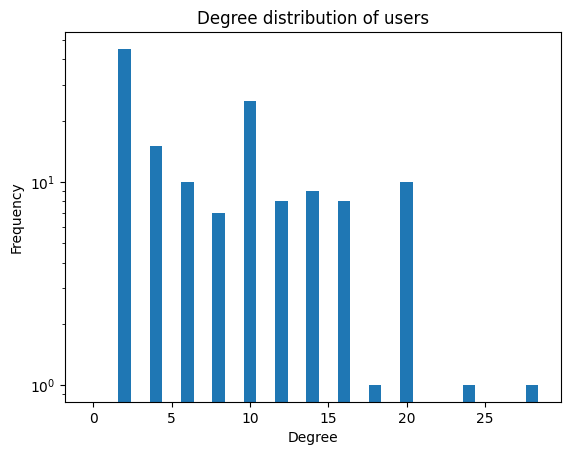

In [11]:
average_degree_users = average_degree(users_subgraph_d) 
print("average degree of users graph: ", average_degree_users)

# plot the degree distribution with bar chart whit log scale
plt.bar(range(len(average_degree_users)), average_degree_users, align='center')
plt.yscale('log')
plt.title("Degree distribution of users")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.show()


In [12]:
import powerlaw
degrees = [users_subgraph_d.degree(n) for n in users_subgraph_d.nodes()]
fit = powerlaw.Fit(degrees)
alpha = fit.alpha
print("alpha:", alpha)


Calculating best minimal value for power law fit
alpha: 24.130577413051153


## Small-worldness and random graphs

In [13]:
# Small-worldness and random graphs
m = users_subgraph.number_of_edges()
n = users_subgraph.number_of_nodes()
p = m / (n*(n-1)/2)  # probability of having an edge between any two nodes
graph_er = nx.erdos_renyi_graph(len(users_subgraph_d), p, directed=True)

#nx.info(graph_er)

In [14]:
print("Clustering coefficient normal graph ", clustering_coefficient)
clustering_coefficient_er = nx.average_clustering(graph_er)
print("Clustering coefficient of Erdos-Renyi graph: ", clustering_coefficient_er)

Clustering coefficient normal graph  0.6263838145981003
Clustering coefficient of Erdos-Renyi graph:  0.02679812056912895


In [15]:
print("average shortest path length of normal graph: ", overall_avg_shortest_path_length)
# calculate the average shortest path length of the ER graph
overall_avg_shortest_path_length_er,avg_shortest_path_lengths_er= average_shortest_path_length(graph_er)
print("average shortest path length of ER user graph: ", overall_avg_shortest_path_length_er)

average shortest path length of normal graph:  1.1174848059841047
average shortest path length of ER user graph:  0.5977704072231436


In [16]:
sigma = sigma(clustering_coefficient,clustering_coefficient_er,overall_avg_shortest_path_length,overall_avg_shortest_path_length_er)
print("sigma of users graph: ", sigma)

sigma of users graph:  12.503424470108602


In [17]:
# Calcola la componente connessa più grande del grafo
largest_cc = max(nx.connected_components(users_subgraph), key=len)

# Crea un nuovo grafo che contiene solo i nodi e gli archi della LCC
users_subgraph_cc = users_subgraph.subgraph(largest_cc).copy()

# Controlla se il nuovo grafo è connesso
conn = nx.is_connected(users_subgraph_cc)
print("Connected: ", conn)


Connected:  True


In [48]:
omega = nx.algorithms.smallworld.omega(users_subgraph_cc, niter=1, nrand=10, seed=42)
#omega(users_subgraph_d, niter=5, nrand=10, seed=42)
print("omega of users graph: ", omega)

omega of users graph:  -0.36682439537329126


## Omega

In [46]:
# Calculate the equivalent lattice network with the same number of nodes and edges as the original graph
n = len(users_subgraph_d.nodes())
k = len(users_subgraph_d.edges()) // n  # The average degree of the original graph
p = clustering_coefficient / k  # The probability of rewiring edges
lattice = nx.watts_strogatz_graph(n, k, p)

# Calculate the average shortest path length and clustering coefficient of the lattice network
lattice_avg_shortest_path_length = nx.average_shortest_path_length(lattice)
lattice_clustering_coefficient = nx.average_clustering(lattice)

omega = ((overall_avg_shortest_path_length_er/overall_avg_shortest_path_length) - (clustering_coefficient/lattice_clustering_coefficient))

print("omega of users graph: ", omega)

omega of users graph:  -0.13535043323163287


In [47]:
# Determine the small-worldness of the original graph
if lattice_avg_shortest_path_length < overall_avg_shortest_path_length and lattice_clustering_coefficient > clustering_coefficient:
    print("The original graph exhibits small-worldness.")
else:
    print("The original graph does not exhibit small-worldness.")

The original graph exhibits small-worldness.


### Small World Index (SWI)

In [38]:
swi = (((overall_avg_shortest_path_length-lattice_avg_shortest_path_length)/(overall_avg_shortest_path_length_er-lattice_avg_shortest_path_length)) * ((clustering_coefficient - clustering_coefficient_er)/(lattice_clustering_coefficient - clustering_coefficient_er)))

print("SWI: ", swi)

SWI:  -0.07459605651098561


In [39]:
print ("Cl",lattice_clustering_coefficient)
print ("C", clustering_coefficient)

print ("L",overall_avg_shortest_path_length )
print ("Lr", overall_avg_shortest_path_length_er)

Cl 0.9345169149926692
C 0.6263838145981003
L 1.1174848059841047
Lr 0.5977704072231436
